# WeatherPy
----

#### Note
* Instructions have been included for each segment. You do not have to follow them exactly, but they are included to help you think through the steps.

In [1]:
# Code to make charts and plots interactive
#%matplotlib notebook

In [1]:
# Dependencies and Setup
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import requests
import time
import os
from scipy.stats import linregress

# Incorporated citipy to determine city based on latitude and longitude
from citipy import citipy
# For displaying of API data more clearly
from pprint import pprint

#import sys
#from config import api_key
#path = "C:\Users\ithmo\OneDrive\Desktop\API Keys"
#sys.path.insert(0, path)

# Import API key
from api_keys import weather_api_key

import json
#with open('data.json', 'w') as outfile:
    #json.dump(JsonWeatherResponse, outfile)

# Output File (CSV)
output_data_file = "output_data/cities.csv"

# Range of latitudes and longitudes
lat_range = (-90, 90)
lng_range = (-180, 180)


#with open('data.json') as json_file:
    #data = json.load(json_file)
#pprint(data)


## Generate Cities List

In [2]:
# List for holding lat_lngs and cities
lat_lngs = []
cities = []

# Create a set of random lat and lng combinations
lats = np.random.uniform(lat_range[0], lat_range[1], size=60)
lngs = np.random.uniform(lng_range[0], lng_range[1], size=60)
lat_lngs = zip(lats, lngs)

# Identify nearest city for each lat, lng combination
for lat_lng in lat_lngs:
    city = citipy.nearest_city(lat_lng[0], lat_lng[1]).city_name
    
    # Capitalizing the first letter of each city word
    city = city.title()
    
    # If the city is unique, then add it to a our cities list
    if city not in cities:
        cities.append(city)
        
# Print the city count to confirm sufficient count
randomCities = len(cities)
randomCities

43

In [3]:
# Setting up the Dataframe to hold 'cities' values
City_DF = pd.DataFrame(cities)

# Copying original list, in case its needed to be referenced later
CityWeather_DF = City_DF

# Changing first column '0' to 'City' which represents the cities generated
CityWeather_DF = CityWeather_DF.rename(columns={0:"City"})

# Order of columns in new dataframe that will hold location/weather data will be:
# City Country Lat Lng Max Temp	Humidity Cloudiness Wind Speed  Date
CityWeather_DF.head(20)


,City
0,Cabo San Lucas
1,Bluff
2,Rikitea
3,Hobart
4,Nouakchott
5,San Quintin
6,Albany
7,Georgetown
8,Broome
9,Klaksvik


### Perform API Calls
* Perform a weather check on each city using a series of successive API calls.
* Include a print log of each city as it'sbeing processed (with the city number and city name).


In [5]:
# SUPPLEMENTAL INFO AND API TESTS

# Creating dynamic URL and checking to see if it works
# Expected output according to API documentation:
# api.openweathermap.org/data/2.5/weather?q={City}&units={unit}&appid={api_key}
# EX) api.openweathermap.org/data/2.5/weather?q=London&units=imperial&appid=APIKEY
# 'units' is 'imperial' for Fahrenheit temp, api key is to be inserted in file "api_keys.py"

# Variables 
#baseURL = "http://api.openweathermap.org/data/2.5/find?q="

#cityName = CityWeather_DF["City"][0]
#cityURL = cityName.replace(" ", "+")
#unitSys = "&units=imperial&appid="

#queryURL = (f'{baseURL}{cityURL}{unitSys}{weather_api_key}') 
#print(queryURL)
#print()

#JsonWeatherResponse = requests.get(queryURL).json()
#pprint(JsonWeatherResponse)


In [4]:
# Start of user facing "data scan"
print()
print(" ----------------------------- ")
print("   BEGINNING DATA RETRIEVAL   ")
print(" ----------------------------- ")
print()

# Index variable to iterate through generated citipy list
nextCity = 0

# Counter to keep track of every 50 succussful city data captures to increase setCounter by 1
recordCounter = 1

# Counter to keep track of how many sets of 50 successful city data captures
setCounter = 1

# Counter to keep track of all times a data API attempt was made (successful or not)
allCityCounter = 1



# For loop to go through however many random cities were generated:
for nextCity in range(randomCities):
   
   # Creating API url dynamically for every city json call/response in city list
   baseURL = "http://api.openweathermap.org/data/2.5/find?q="
   
   # cityName may have spaces""", so removing them for the url link and replacing them with a "+"
   cityName = CityWeather_DF["City"][nextCity]
   
   # using new variable for url to keep the original cityName format for later use in status message
   cityURL = cityName.replace(" ", "+")
   
   unitSys = "&units=imperial&appid="
   queryURL = (f'{baseURL}{cityURL}{unitSys}{weather_api_key}')  
   
   # Copying created API url for current city in another variable to be used in error message
   ReviewURL = queryURL

   JsonWeatherResponse = requests.get(queryURL).json()
   
   # **Reseting Humidity > 100% checker to defauly False
   humidityCheck = False
   


   # Code will try to execute but be cognizant for Exception errors, as well as coded error API checks
   try:

      # recordCounter will reset itself and add 1 to the "Set" display every 50 successful city entries   
      if recordCounter == 51:
         recordCounter = 0
         setCounter += 1

      # if API response returns an incomplete dataset (count=0) 
      # or a dataset with too much data that will errors out (ie count = 5)
      # or webpage returns a cod code/Response other than 200 (ie 404, etc). 
      # this Code will proactively not enter data in and return an error
      # message/update to user with api http. link and continue to process through loop and counts. 
      # These entries/rows will be deleted later 
      if JsonWeatherResponse["count"] > 3 or \
         JsonWeatherResponse["count"] == '0' or \
         JsonWeatherResponse["cod"] != "200":
         
         print()
         print(f'Data for {cityName} is corrupted. Skipping. Can review URL below...')
         print(ReviewURL)
         print()
         
         nextCity += 1
         allCityCounter += 1
         humidityCheck = True

      # Create and populate 9 columns with API data and a humidity check for current city (nextCity/index)
      else:
         CityWeather_DF.loc[nextCity, "Country"] = JsonWeatherResponse['list'][0]["sys"]["country"]
         CityWeather_DF.loc[nextCity, "Lat"] = JsonWeatherResponse['list'][0]["coord"]["lat"]
         CityWeather_DF.loc[nextCity, "Lng"] = JsonWeatherResponse['list'][0]["coord"]["lon"]
         CityWeather_DF.loc[nextCity, "Max Temp"] = JsonWeatherResponse['list'][0]["main"]["temp_max"]
         
         CityWeather_DF.loc[nextCity, "Humidity"] = JsonWeatherResponse['list'][0]["main"]["humidity"]
         # ** Will perform a check on the Humidty value here and "mark it down"
                  
         CityWeather_DF.loc[nextCity, "Cloudiness"] = JsonWeatherResponse['list'][0]["clouds"]["all"]
         CityWeather_DF.loc[nextCity, "Wind Speed"] = JsonWeatherResponse['list'][0]["wind"]["speed"]
         
         # Format data for readability
         CityWeather_DF.loc[nextCity, "Date"] = time.strftime(' %m/%d/%Y', time.localtime(JsonWeatherResponse['list'][0]["dt"]))
         
            # **Perform a check on if Humidity % > 100 (to mark for deletion later)
            # Assigning value to a new column to track
         if CityWeather_DF["Humidity"][nextCity] >= 100.00:
            humidityCheck = True
            CityWeather_DF.loc[nextCity, "Humidity > 100%"] = humidityCheck
         else:
            humidityCheck = False
            CityWeather_DF.loc[nextCity, "Humidity > 100%"] = humidityCheck
            # 'True' columned cities will have their data/ROWS deleted later in a new DF
            # 'False' columned cities wll retain original data. New column will then be deleted during clean
         
         # Message progress detailing number of successful sets, all attempts vs full list, and the city       
         print(f"Processing Record.. { recordCounter } of Set { setCounter }  ({allCityCounter} / {randomCities})   |   {cityName}")

         # Iterate counts
         nextCity += 1
         recordCounter += 1
         allCityCounter += 1
            
      # In the event of an indexerror/incomplet API, no data will be marked and loop/count will be iterated   
   except IndexError:
      print()
      print(f'No Data for {cityName}. Skipping entry...')
      print()
      allCityCounter += 1
      nextCity += 1
      pass

# End of "data scan"
print()
print(" ----------------------------- ")
print("   DATA RETRIEVAL COMPLETE   ")
print(" ----------------------------- ")
print()




 ----------------------------- 
   BEGINNING DATA RETRIEVAL   
 ----------------------------- 

Processing Record.. 1 of Set 1  (1 / 43)   |   Cabo San Lucas
Processing Record.. 2 of Set 1  (2 / 43)   |   Bluff
Processing Record.. 3 of Set 1  (3 / 43)   |   Rikitea

Data for Hobart is corrupted. Skipping. Can review URL below...
http://api.openweathermap.org/data/2.5/find?q=Hobart&units=imperial&appid=8f818372da0128048522d56de3aaa224

Processing Record.. 4 of Set 1  (5 / 43)   |   Nouakchott
Processing Record.. 5 of Set 1  (6 / 43)   |   San Quintin

Data for Albany is corrupted. Skipping. Can review URL below...
http://api.openweathermap.org/data/2.5/find?q=Albany&units=imperial&appid=8f818372da0128048522d56de3aaa224


Data for Georgetown is corrupted. Skipping. Can review URL below...
http://api.openweathermap.org/data/2.5/find?q=Georgetown&units=imperial&appid=8f818372da0128048522d56de3aaa224


Data for Broome is corrupted. Skipping. Can review URL below...
http://api.openweatherma

In [6]:
# Display column counts, calculations overview (including max values ie "Humidity"), and dataframe preview
print(CityWeather_DF.count())
print()
print()
print(CityWeather_DF.describe())
print()
print()
CityWeather_DF.head(20)

City               43
Country            34
Lat                34
Lng                34
Max Temp           34
Humidity           34
Cloudiness         34
Wind Speed         34
Date               34
Humidity > 100%    34
dtype: int64


             Lat         Lng   Max Temp    Humidity  Cloudiness  Wind Speed
count  34.000000   34.000000  34.000000   34.000000   34.000000   34.000000
mean    5.172459   17.495141  60.572647   71.088235   59.470588    9.012059
std    39.234014   99.923306  28.658999   23.728729   41.437236    5.955677
min   -54.800000 -173.300000  -9.150000   10.000000    0.000000    1.990000
25%   -24.430100  -68.518550  50.252500   67.000000    8.750000    4.610000
50%     3.728100   26.789300  67.200000   75.500000   75.000000    8.655000
75%    28.654150  101.798350  82.742500   87.500000   98.750000   11.215000
max    72.786800  168.864300  95.000000  100.000000  100.000000   32.210000




,City,Country,Lat,Lng,Max Temp,Humidity,Cloudiness,Wind Speed,Date,Humidity > 100%
0,Cabo San Lucas,MX,22.8909,-109.9124,57.99,50.0,2.0,1.99,03/15/2021,False
1,Bluff,NZ,-46.6000,168.3333,55.00,72.0,5.0,3.00,03/15/2021,False
2,Rikitea,PF,-23.1203,-134.9692,80.31,77.0,47.0,6.67,03/15/2021,False
3,Hobart,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,Nouakchott,MR,18.0858,-15.9785,60.80,72.0,0.0,4.61,03/15/2021,False
5,San Quintin,MX,30.4833,-115.9500,54.39,80.0,85.0,14.14,03/15/2021,False
6,Albany,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,Georgetown,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,Broome,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,Klaksvik,FO,62.2266,-6.5890,33.80,93.0,100.0,3.83,03/15/2021,False


## Inspect the data and remove the cities where the humidity > 100%.
----
Skip this step if there are no cities that have humidity > 100%. 

In [7]:
# _______ CityWeather_DF _______
# Clean the data of any blanks, duplicates, or rows with null/NaN values.
CityWeather_DF.replace("", np.nan, inplace=True)
CityWeather_DF.replace("NaN", np.nan, inplace=True)
CityWeather_DF = CityWeather_DF.drop_duplicates()
CityWeather_DF = CityWeather_DF.dropna()
# Check to see if all rows have the same count and dataframe preview.
#print(CityWeather_DF.count())
#print()
#CityWeather_DF.head(20)


# Create new copy of dataframe. 
clean_city_dataDF = CityWeather_DF.copy()
# ** See next code snippet regarding new "100% Humidity" DF

# Once the copy is complete, the orignal dataframe will be cleaned of the extra ["Humidity > 100%"] row
# Displaying cleaned "original/spaceless" DF
del CityWeather_DF["Humidity > 100%"]
print(CityWeather_DF.count())
print()
CityWeather_DF.head(20)


City          34
Country       34
Lat           34
Lng           34
Max Temp      34
Humidity      34
Cloudiness    34
Wind Speed    34
Date          34
dtype: int64



,City,Country,Lat,Lng,Max Temp,Humidity,Cloudiness,Wind Speed,Date
0,Cabo San Lucas,MX,22.8909,-109.9124,57.99,50.0,2.0,1.99,03/15/2021
1,Bluff,NZ,-46.6000,168.3333,55.00,72.0,5.0,3.00,03/15/2021
2,Rikitea,PF,-23.1203,-134.9692,80.31,77.0,47.0,6.67,03/15/2021
4,Nouakchott,MR,18.0858,-15.9785,60.80,72.0,0.0,4.61,03/15/2021
5,San Quintin,MX,30.4833,-115.9500,54.39,80.0,85.0,14.14,03/15/2021
9,Klaksvik,FO,62.2266,-6.5890,33.80,93.0,100.0,3.83,03/15/2021
10,Padang,ID,-0.9492,100.3543,86.00,70.0,20.0,5.75,03/15/2021
11,Bredasdorp,ZA,-34.5322,20.0403,64.40,94.0,100.0,9.22,03/15/2021
12,Atuona,PF,-9.8000,-139.0333,80.15,71.0,3.0,10.09,03/15/2021
13,Umm Kaddadah,SD,13.6017,26.6876,91.90,10.0,100.0,14.09,03/15/2021


In [8]:
# _______ clean_city_dataDF _______
# Make a new DataFrame equal to the city data to drop all humidity outliers by index.

# **This DF copy will be cleaned further of cities with +100% humidty by removing rows of True
clean_city_dataDF = clean_city_dataDF[clean_city_dataDF["Humidity > 100%"] != True]
# And then Humidity column itself and display DF summary
del clean_city_dataDF["Humidity > 100%"]
print(clean_city_dataDF.count())
print()
clean_city_dataDF.head(20)

City          32
Country       32
Lat           32
Lng           32
Max Temp      32
Humidity      32
Cloudiness    32
Wind Speed    32
Date          32
dtype: int64



,City,Country,Lat,Lng,Max Temp,Humidity,Cloudiness,Wind Speed,Date
0,Cabo San Lucas,MX,22.8909,-109.9124,57.99,50.0,2.0,1.99,03/15/2021
1,Bluff,NZ,-46.6000,168.3333,55.00,72.0,5.0,3.00,03/15/2021
2,Rikitea,PF,-23.1203,-134.9692,80.31,77.0,47.0,6.67,03/15/2021
4,Nouakchott,MR,18.0858,-15.9785,60.80,72.0,0.0,4.61,03/15/2021
5,San Quintin,MX,30.4833,-115.9500,54.39,80.0,85.0,14.14,03/15/2021
9,Klaksvik,FO,62.2266,-6.5890,33.80,93.0,100.0,3.83,03/15/2021
10,Padang,ID,-0.9492,100.3543,86.00,70.0,20.0,5.75,03/15/2021
11,Bredasdorp,ZA,-34.5322,20.0403,64.40,94.0,100.0,9.22,03/15/2021
12,Atuona,PF,-9.8000,-139.0333,80.15,71.0,3.0,10.09,03/15/2021
13,Umm Kaddadah,SD,13.6017,26.6876,91.90,10.0,100.0,14.09,03/15/2021


### Convert Raw Data to DataFrame
* Export the city data into a .csv.
* Display the DataFrame

In [9]:
# Summary display of CityWeather_DF dataframe and export to .csv
print(CityWeather_DF.count())
print()

print(CityWeather_DF.describe())
print()

CityWeather_DF.to_csv('../output_data/CityWeather.csv')
print(CityWeather_DF.head(20))
print()


             Lat         Lng   Max Temp    Humidity  Cloudiness  Wind Speed
count  34.000000   34.000000  34.000000   34.000000   34.000000   34.000000
mean    5.172459   17.495141  60.572647   71.088235   59.470588    9.012059
std    39.234014   99.923306  28.658999   23.728729   41.437236    5.955677
min   -54.800000 -173.300000  -9.150000   10.000000    0.000000    1.990000
25%   -24.430100  -68.518550  50.252500   67.000000    8.750000    4.610000
50%     3.728100   26.789300  67.200000   75.500000   75.000000    8.655000
75%    28.654150  101.798350  82.742500   87.500000   98.750000   11.215000
max    72.786800  168.864300  95.000000  100.000000  100.000000   32.210000

               City Country      Lat       Lng  Max Temp  Humidity  \
0    Cabo San Lucas      MX  22.8909 -109.9124     57.99      50.0   
1             Bluff      NZ -46.6000  168.3333     55.00      72.0   
2           Rikitea      PF -23.1203 -134.9692     80.31      77.0   
4        Nouakchott      MR  18.085

In [9]:
# Summary display of clean_city_dataDF dataframe and export to .csv
print(clean_city_dataDF.count())
print()

print(clean_city_dataDF.describe())
print()

clean_city_dataDF.to_csv('../output_data/CleanCityWeatherData.csv')
print(clean_city_dataDF.head(20))
print()


             Lat         Lng   Max Temp   Humidity  Cloudiness  Wind Speed
count  22.000000   22.000000  22.000000  22.000000   22.000000   22.000000
mean   11.030905   25.549232  54.393182  80.136364   72.090909    8.149545
std    39.113729  101.594959  30.772949  18.820696   31.140097    4.585219
min   -53.150000 -175.200000  -8.300000  23.000000    3.000000    1.990000
25%   -19.377925  -46.557225  32.000000  75.250000   52.500000    4.505000
50%    -1.380950   42.238700  65.300000  86.500000   89.500000    6.385000
75%    49.479900  108.141150  78.547500  92.500000   97.750000   12.407500
max    72.786800  170.313300  84.470000  95.000000  100.000000   15.660000

                      City Country      Lat       Lng  Max Temp  Humidity  \
1               Port Hardy      CA  50.6996 -127.4199     37.40      86.0   
3                   Faanui      PF -16.4833 -151.7500     83.03      75.0   
4                Esperance      AU -33.8667  121.9000     73.40      35.0   
5               

## Plotting the Data
* Use proper labeling of the plots using plot titles (including date of analysis) and axes labels.
* Save the plotted figures as .pngs.

## Latitude vs. Temperature Plot

C:\ProgramData\Anaconda3\lib\site-packages\matplotlib\collections.py:922: RuntimeWarning: invalid value encountered in sqrt
  scale = np.sqrt(self._sizes) * dpi / 72.0 * self._factor


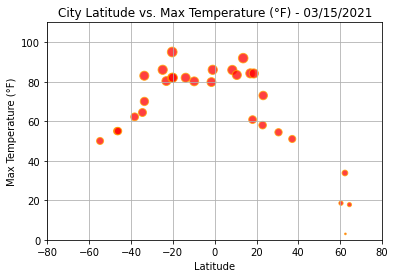

 Based on our 'Latitude vs. Max Temperatur' scatter plot, we can see that as one gets closer to the equator (0), the temperature arches upwards in a curve to reflect the rise in temperatur before trending down as we move away from the equator latitude.


In [10]:
# Latitude vs. Max Temperature Plot
plt.scatter(clean_city_dataDF["Lat"], clean_city_dataDF["Max Temp"], facecolor="red", edgecolors="orange",
           alpha=0.75, s=clean_city_dataDF["Max Temp"])
plt.title("City Latitude vs. Max Temperature (°F) - 03/15/2021")
plt.grid()


plt.xlim(-80,80)
plt.ylim(0,110)

plt.xlabel("Latitude")
plt.ylabel("Max Temperature (°F)")
#plt.savefig("../Image/Lat_vs_MaxTemp.png", bbox_inches="tight")
plt.show()

print(" Based on our 'Latitude vs. Max Temperatur' scatter plot, we can see that as one gets closer to the equator (0), the temperature arches upwards in a curve to reflect the rise in temperatur before trending down as we move away from the equator latitude.")

## Latitude vs. Humidity Plot

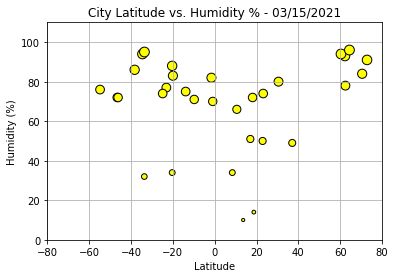

There doesn't seem to be a discernable pattern or relation between Humidity and the Latitude one is at. The Humidity is uniformly scattered no matter how close or far away from the Equator.


In [11]:
# Latitude vs. Humidity Plot
plt.scatter(clean_city_dataDF["Lat"], clean_city_dataDF["Humidity"], facecolor="yellow", edgecolors="black",
           alpha=1, s=clean_city_dataDF["Humidity"])

plt.title("City Latitude vs. Humidity % - 03/15/2021")
plt.grid()

plt.xlim(-80,80)
plt.ylim(0,110)

plt.xlabel("Latitude")
plt.ylabel("Humidity (%)")
#plt.savefig("../Image/Lat_vs_Humidity.png", bbox_inches="tight")
plt.show()

print("There doesn't seem to be a discernable pattern or relation between Humidity and the Latitude one is at. The Humidity is uniformly scattered no matter how close or far away from the Equator.")

## Latitude vs. Cloudiness Plot

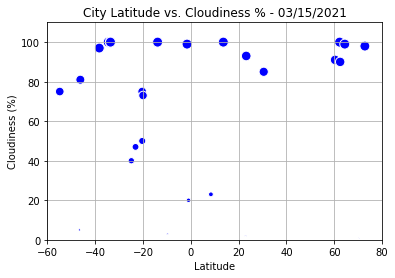

Just as with the observation regarding Humidity vs Latitude, there seems to be no pattern or trend to signify a direct correlation between Cloudiness and the city's Latitude. Many cities seem to share a high percentage/concentration of cloudiness the world over.


In [12]:
# Latitude vs. Cloudiness Plot
plt.scatter(clean_city_dataDF["Lat"], clean_city_dataDF["Cloudiness"], facecolor="blue", edgecolors="white",
           alpha=1, s=clean_city_dataDF["Cloudiness"])

plt.title("City Latitude vs. Cloudiness % - 03/15/2021")
plt.grid()

plt.xlim(-60,80)
plt.ylim(0,110)

plt.xlabel("Latitude")
plt.ylabel("Cloudiness (%)")
#plt.savefig("../Image/Lat_vs_Cloudiness.png", bbox_inches="tight")
plt.show()

print("Just as with the observation regarding Humidity vs Latitude, there seems to be no pattern or trend to signify a direct correlation between Cloudiness and the city's Latitude. Many cities seem to share a high percentage/concentration of cloudiness the world over.")

## Latitude vs. Wind Speed Plot

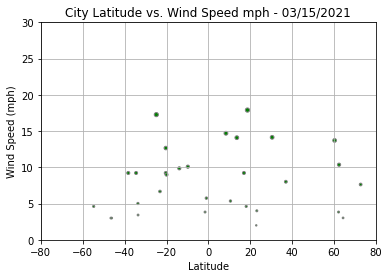

The only observation I can see is more regarding the low wind speed, generally speaking, across most cities. The wind speed doesn't really go much past 20mph, regardless of latitude and equatorial distance. No relationship.


In [14]:
# Latitude vs. Wind Speed Plot
plt.scatter(clean_city_dataDF["Lat"], clean_city_dataDF["Wind Speed"], facecolor="green", edgecolors="gray",
           alpha=1, s=clean_city_dataDF["Wind Speed"])

plt.title("City Latitude vs. Wind Speed mph - 03/15/2021")
plt.grid()

plt.xlim(-80,80)
plt.ylim(0,30)

plt.xlabel("Latitude")
plt.ylabel("Wind Speed (mph)")
#plt.savefig("../Image/Lat_vs_WindSpeed.png", bbox_inches="tight")
plt.show()

print("The only observation I can see is more regarding the low wind speed, generally speaking, across most cities. The wind speed doesn't really go much past 20mph, regardless of latitude and equatorial distance. No relationship.")

## Linear Regression

In [15]:
# Must separate the plots into a Northern Hemisphere (greater than or equal to 0 degrees latitude) and a Southern Hemisphere (less than 0 degrees latitude) dataframe grouping. Referencing 'Humidity>100%' check code: CityWeather_DF.loc[nextCity, "Humidity > 100%"] = CityWeather_DF["Humidity"][nextCity] >= 100.00:
# Northern Hemispheres Cities
NorthernHemi_DF = clean_city_dataDF.loc[clean_city_dataDF["Lat"] >= 0]
NorthernHemi_DF.head(20) # Test to see if returned Latitude values are > 0, Lat should be positive
#clean_city_dataDF.head(20) # Compare results to normal dataframe, if need.

,City,Country,Lat,Lng,Max Temp,Humidity,Cloudiness,Wind Speed,Date
0,Cabo San Lucas,MX,22.8909,-109.9124,57.99,50.0,2.0,1.99,03/15/2021
4,Nouakchott,MR,18.0858,-15.9785,60.80,72.0,0.0,4.61,03/15/2021
5,San Quintin,MX,30.4833,-115.9500,54.39,80.0,85.0,14.14,03/15/2021
9,Klaksvik,FO,62.2266,-6.5890,33.80,93.0,100.0,3.83,03/15/2021
13,Umm Kaddadah,SD,13.6017,26.6876,91.90,10.0,100.0,14.09,03/15/2021
14,Salalah,OM,17.0151,54.0924,84.20,51.0,0.0,9.22,03/15/2021
16,Vanavara,RU,60.3400,102.2797,18.52,94.0,91.0,13.71,03/15/2021
18,Upernavik,GL,72.7868,-56.1549,-9.15,91.0,98.0,7.63,03/15/2021
20,Clyde River,CA,70.4692,-68.5914,-5.80,84.0,1.0,32.21,03/15/2021
24,Garowe,SO,8.4054,48.4845,85.91,34.0,23.0,14.70,03/15/2021


In [16]:
# Southern Hemispheres Cities
SouthernHemi_DF = clean_city_dataDF.loc[clean_city_dataDF["Lat"] <= 0]
SouthernHemi_DF.head(20) # Test to see if returned Latitude values are < 0, Lat should be negative
#clean_city_dataDF.head(20) # Compare results to normal dataframe, if need.

,City,Country,Lat,Lng,Max Temp,Humidity,Cloudiness,Wind Speed,Date
1,Bluff,NZ,-46.6000,168.3333,55.00,72.0,5.0,3.00,03/15/2021
2,Rikitea,PF,-23.1203,-134.9692,80.31,77.0,47.0,6.67,03/15/2021
10,Padang,ID,-0.9492,100.3543,86.00,70.0,20.0,5.75,03/15/2021
11,Bredasdorp,ZA,-34.5322,20.0403,64.40,94.0,100.0,9.22,03/15/2021
12,Atuona,PF,-9.8000,-139.0333,80.15,71.0,3.0,10.09,03/15/2021
15,Ushuaia,AR,-54.8000,-68.3000,50.00,76.0,75.0,4.61,03/15/2021
19,Port Hedland,AU,-20.3167,118.5667,95.00,34.0,50.0,12.66,03/15/2021
21,Bambous Virieux,MU,-20.3428,57.7575,82.00,88.0,75.0,9.22,03/15/2021
27,Codrington,AU,-38.2667,141.9667,62.20,86.0,97.0,9.22,03/15/2021
29,Busselton,AU,-33.6500,115.3333,82.99,32.0,100.0,5.01,03/15/2021


In [ ]:
# Linear Regression formula is going to be: 
# (slope, intercept, rvalue, pvalue, stderr) = linregress(x_values, y_values)
# Will need variables for x/y _values which will be the hemisphere dataframes': 
# Lat vs. Max Temp / Humidity / Cloudiness / Wind Speed 

# Referencing class exercise on Regression for code:
    # x_values = _DF["xxx"]
    # y_values = _DF["xxx"]
    # (slope, intercept, rvalue, pvalue, stderr) = linregress(x_values, y_values)
    # regress_values = x_values * slope + intercept
    # line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
    # plt.scatter(x_values,y_values)
    # plt.plot(x_values,regress_values,"r-")
    # plt.annotate(line_eq,(6,10),fontsize=15,color="red")
    # plt.xlabel('xxx')
    # plt.ylabel('xxx')
    # print(f"The r-squared is: {rvalue**2}")
    # plt.show()

# Will plug in values/columns and reuse code format to keep charts consistent

####  Northern Hemisphere - Max Temp vs. Latitude Linear Regression

The r-squared is: 0.9275482090822894


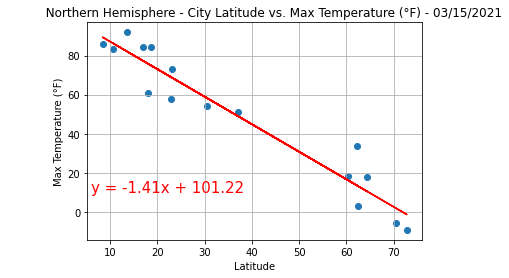

In [17]:
# Lat vs. Max Temp / Humidity (%) / Cloudiness (%) / Wind Speed (mph) / Latitude  / Max Temperature (°F)
# ....for NorthernHemi_DF / SouthernHemi_DF

plt.title("          Northern Hemisphere - City Latitude vs. Max Temperature (°F) - 03/15/2021")
plt.grid()
x_values = NorthernHemi_DF["Lat"]
y_values = NorthernHemi_DF["Max Temp"]
(slope, intercept, rvalue, pvalue, stderr) = linregress(x_values, y_values)
regress_values = x_values * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
plt.scatter(x_values,y_values)
plt.plot(x_values,regress_values,"r-")
plt.annotate(line_eq,(6,10),fontsize=15,color="red")
plt.xlabel('Latitude')
plt.ylabel('Max Temperature (°F)')
print(f"The r-squared is: {rvalue**2}")
plt.show()
#plt.savefig("../Image/MaxTemp_vs_Lat_NorthHemi.png", bbox_inches="tight")
print("  ")

####  Southern Hemisphere - Max Temp vs. Latitude Linear Regression

The r-squared is: 0.6503581283714447


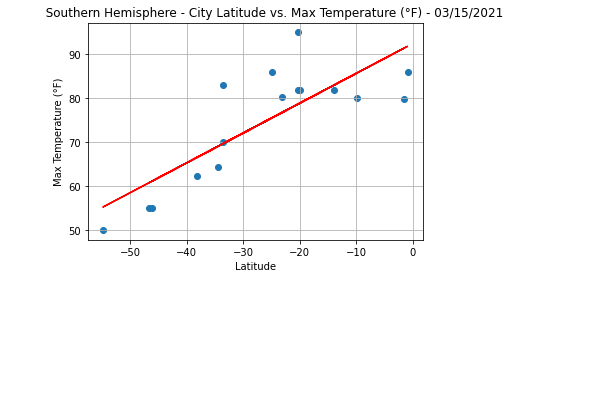

In [18]:
# Lat vs. Max Temp / Humidity (%) / Cloudiness (%) / Wind Speed (mph) / Latitude  / Max Temperature (°F)
# ....for NorthernHemi_DF / SouthernHemi_DF

plt.title("          Southern Hemisphere - City Latitude vs. Max Temperature (°F) - 03/15/2021")
plt.grid()
x_values = SouthernHemi_DF["Lat"]
y_values = SouthernHemi_DF["Max Temp"]
(slope, intercept, rvalue, pvalue, stderr) = linregress(x_values, y_values)
regress_values = x_values * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
plt.scatter(x_values,y_values)
plt.plot(x_values,regress_values,"r-")
plt.annotate(line_eq,(6,10),fontsize=15,color="red")
plt.xlabel('Latitude')
plt.ylabel('Max Temperature (°F)')
print(f"The r-squared is: {rvalue**2}")
plt.show()
#plt.savefig("../Image/MaxTemp_vs_Lat_SouthHemi.png", bbox_inches="tight")
print("  ")

####  Northern Hemisphere - Humidity (%) vs. Latitude Linear Regression

The r-squared is: 0.5519844319222059


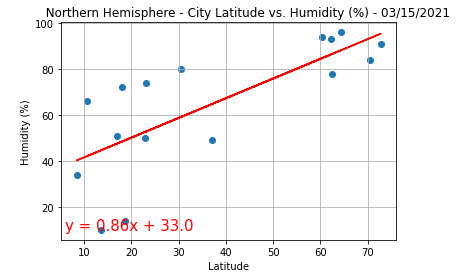

In [19]:
# Lat vs. Max Temp / Humidity (%) / Cloudiness (%) / Wind Speed (mph) / Latitude  / Max Temperature (°F)
# ....for NorthernHemi_DF / SouthernHemi_DF

plt.title("          Northern Hemisphere - City Latitude vs. Humidity (%) - 03/15/2021")
plt.grid()
x_values = NorthernHemi_DF["Lat"]
y_values = NorthernHemi_DF["Humidity"]
(slope, intercept, rvalue, pvalue, stderr) = linregress(x_values, y_values)
regress_values = x_values * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
plt.scatter(x_values,y_values)
plt.plot(x_values,regress_values,"r-")
plt.annotate(line_eq,(6,10),fontsize=15,color="red")
plt.xlabel('Latitude')
plt.ylabel('Humidity (%)')
print(f"The r-squared is: {rvalue**2}")
plt.show()
#plt.savefig("../Image/Humidity_vs_Lat_NorthHemi.png", bbox_inches="tight")
print("  ")

####  Southern Hemisphere - Humidity (%) vs. Latitude Linear Regression

The r-squared is: 0.001440998265381018


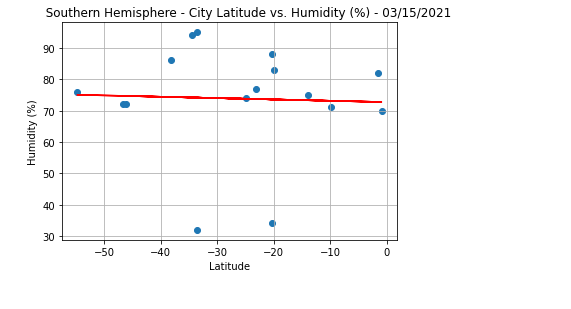

In [20]:
# Lat vs. Max Temp / Humidity (%) / Cloudiness (%) / Wind Speed (mph) / Latitude  / Max Temperature (°F)
# ....for NorthernHemi_DF / SouthernHemi_DF

plt.title("          Southern Hemisphere - City Latitude vs. Humidity (%) - 03/15/2021")
plt.grid()
x_values = SouthernHemi_DF["Lat"]
y_values = SouthernHemi_DF["Humidity"]
(slope, intercept, rvalue, pvalue, stderr) = linregress(x_values, y_values)
regress_values = x_values * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
plt.scatter(x_values,y_values)
plt.plot(x_values,regress_values,"r-")
plt.annotate(line_eq,(6,10),fontsize=15,color="red")
plt.xlabel('Latitude')
plt.ylabel('Humidity (%)')
print(f"The r-squared is: {rvalue**2}")
plt.show()
#plt.savefig("../Image/Humidity_vs_Lat_SouthHemi.png", bbox_inches="tight")
print("  ")

####  Northern Hemisphere - Cloudiness (%) vs. Latitude Linear Regression

The r-squared is: 0.23628364049537587


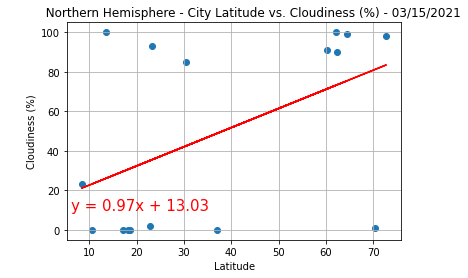

In [21]:
# Lat vs. Max Temp / Humidity (%) / Cloudiness (%) / Wind Speed (mph) / Latitude  / Max Temperature (°F)
# ....for NorthernHemi_DF / SouthernHemi_DF

plt.title("          Northern Hemisphere - City Latitude vs. Cloudiness (%) - 03/15/2021")
plt.grid()
x_values = NorthernHemi_DF["Lat"]
y_values = NorthernHemi_DF["Cloudiness"]
(slope, intercept, rvalue, pvalue, stderr) = linregress(x_values, y_values)
regress_values = x_values * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
plt.scatter(x_values,y_values)
plt.plot(x_values,regress_values,"r-")
plt.annotate(line_eq,(6,10),fontsize=15,color="red")
plt.xlabel('Latitude')
plt.ylabel('Cloudiness (%)')
print(f"The r-squared is: {rvalue**2}")
plt.show()
#plt.savefig("../Image/Cloudiness_vs_Lat_NorthHemi.png", bbox_inches="tight")
print("  ")

####  Southern Hemisphere - Cloudiness (%) vs. Latitude Linear Regression

The r-squared is: 0.034250419059915334


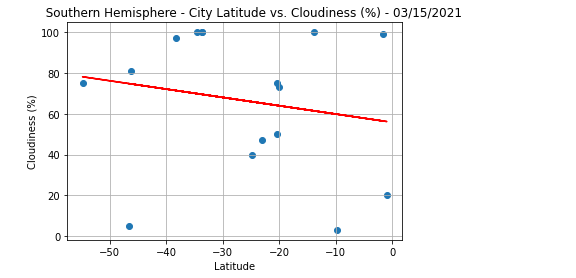

In [22]:
# Lat vs. Max Temp / Humidity (%) / Cloudiness (%) / Wind Speed (mph) / Latitude  / Max Temperature (°F)
# ....for NorthernHemi_DF / SouthernHemi_DF

plt.title("          Southern Hemisphere - City Latitude vs. Cloudiness (%) - 03/15/2021")
plt.grid()
x_values = SouthernHemi_DF["Lat"]
y_values = SouthernHemi_DF["Cloudiness"]
(slope, intercept, rvalue, pvalue, stderr) = linregress(x_values, y_values)
regress_values = x_values * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
plt.scatter(x_values,y_values)
plt.plot(x_values,regress_values,"r-")
plt.annotate(line_eq,(6,10),fontsize=15,color="red")
plt.xlabel('Latitude')
plt.ylabel('Cloudiness (%)')
print(f"The r-squared is: {rvalue**2}")
plt.show()
#plt.savefig("../Image/Cloudiness_vs_Lat_SouthHemi.png", bbox_inches="tight")
print("  ")

####  Northern Hemisphere - Wind Speed (mph) vs. Latitude Linear Regression

The r-squared is: 0.026143377881782257


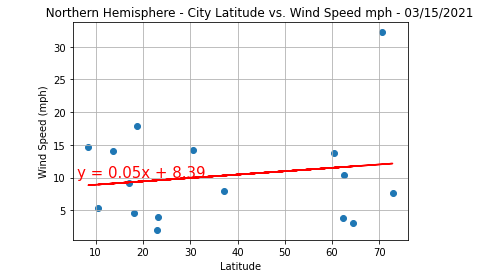

In [23]:
# Lat vs. Max Temp / Humidity (%) / Cloudiness (%) / Wind Speed (mph) / Latitude  / Max Temperature (°F)
# ....for NorthernHemi_DF / SouthernHemi_DF

plt.title("          Northern Hemisphere - City Latitude vs. Wind Speed mph - 03/15/2021")
plt.grid()
x_values = NorthernHemi_DF["Lat"]
y_values = NorthernHemi_DF["Wind Speed"]
(slope, intercept, rvalue, pvalue, stderr) = linregress(x_values, y_values)
regress_values = x_values * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
plt.scatter(x_values,y_values)
plt.plot(x_values,regress_values,"r-")
plt.annotate(line_eq,(6,10),fontsize=15,color="red")
plt.xlabel('Latitude')
plt.ylabel('Wind Speed (mph)')
print(f"The r-squared is: {rvalue**2}")
plt.show()
#plt.savefig("../Image/WindSpeed_vs_Lat_NorthHemi.png", bbox_inches="tight")
print("  ")

####  Southern Hemisphere - Wind Speed (mph) vs. Latitude Linear Regression

The r-squared is: 0.08665913411192462


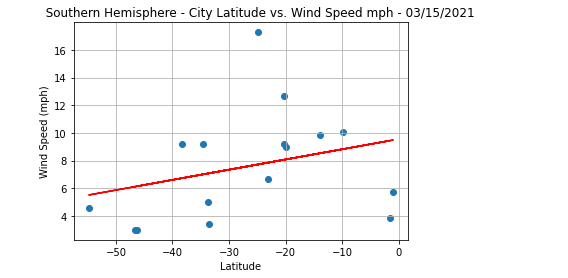

In [24]:
# Lat vs. Max Temp / Humidity (%) / Cloudiness (%) / Wind Speed (mph) / Latitude  / Max Temperature (°F)
# ....for NorthernHemi_DF / SouthernHemi_DF

plt.title("          Southern Hemisphere - City Latitude vs. Wind Speed mph - 03/15/2021")
plt.grid()
x_values = SouthernHemi_DF["Lat"]
y_values = SouthernHemi_DF["Wind Speed"]
(slope, intercept, rvalue, pvalue, stderr) = linregress(x_values, y_values)
regress_values = x_values * slope + intercept
line_eq = "y = " + str(round(slope,2)) + "x + " + str(round(intercept,2))
plt.scatter(x_values,y_values)
plt.plot(x_values,regress_values,"r-")
plt.annotate(line_eq,(6,10),fontsize=15,color="red")
plt.xlabel('Latitude')
plt.ylabel('Wind Speed (mph)')
print(f"The r-squared is: {rvalue**2}")
plt.show()
#plt.savefig("../Image/WindSpeed_vs_Lat_SouthHemi.png", bbox_inches="tight")
print("  ")